# Q1

## 问题分析

> **问题1**  对经中路-纬中路交叉口，根据**车流量的差异**，可**将一天分成若干个时段**，估计**不同时段各个相位**（包括四个方向直行、转弯）车流量。

对经中路-纬中路交叉口：数据筛选

分为四个相位：需要追踪车牌的流向

分为工作日与非工作日：拆分讨论

每天分为若干时段：聚类

分别估计车流量：根据经验数据估计正常值

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## 1. 数据准备

**读取数据**

一定要使用`encoding='gbk'`，否则会报错。

**数据清洗**

+ 去除`'无车牌'`与`'unnnowk'`
+ 去除仅出现过一次的车牌
+ 把时间转化为时间戳
+ 按照车牌-时间排序
+ 替换方向列

In [2]:
original_data = pd.read_csv(r'D:\college\MCM\24\E\Attatchment2.csv', encoding='gbk')

original_data = original_data.loc[(original_data['车牌号']!='无车牌') & (original_data['车牌号']!='unnnowk'),:].copy()
original_data = original_data.loc[original_data['车牌号'].map(original_data['车牌号'].value_counts()) > 1, :].copy()

original_data["时间"] = pd.to_datetime(original_data["时间"])
original_data.sort_values(['车牌号','时间'], inplace=True)

direction_map = {
    1: '由东向西',
    2: '由西向东',
    3: '由南向北',
    4: '由北向南'
}
original_data['方向'] = original_data['方向'].map(direction_map)

original_data

,方向,时间,车牌号,交叉口
36395,由北向南,2024-04-01 17:16:15.624,3B04AU8,环西路-纬中路
2827631,由西向东,2024-04-01 17:18:59.713,3B04AU8,经二路-纬中路
3310793,由西向东,2024-04-01 17:20:46.845,3B04AU8,经三路-纬中路
4922568,由东向西,2024-04-01 19:07:34.000,3B04AU8,经中路-纬中路
3278655,由东向西,2024-04-01 19:08:41.471,3B04AU8,经三路-纬中路
...,...,...,...,...
7396459,由南向北,2024-04-26 13:38:51.000,礼OB367Y,经中路-纬一路
6735241,由南向北,2024-04-26 14:29:41.338,礼OB367Y,经中路-环北路
6719735,由北向南,2024-04-26 15:19:03.591,礼OB367Y,经中路-环北路
8625745,由西向东,2024-05-03 16:14:39.000,礼Q36CEA,经中路-环南路


## 追踪每个车牌的去向，判断相位

判定一辆车确实发生了拐弯：

+ 两次出现在路口的时间间隔在一定范围内
+ 第二次出现的路口是与经中路-纬中路交叉口相邻的路口
+ 第二次出现的方向的后方对着经中路-纬中路交叉口

In [3]:
original_data.loc[original_data['车牌号']=='EF88IJ6',:].copy()

,方向,时间,车牌号,交叉口
6263754,由北向南,2024-04-06 10:34:14.916,EF88IJ6,经中路-环北路
6999977,由北向南,2024-04-06 10:35:28.000,EF88IJ6,经中路-纬一路
5034230,由北向南,2024-04-06 10:37:14.000,EF88IJ6,经中路-纬中路
4030519,由东向西,2024-04-06 14:40:13.408,EF88IJ6,纬中路-景区出入口
5027703,由东向西,2024-04-06 14:45:04.000,EF88IJ6,经中路-纬中路
3373506,由东向西,2024-04-06 14:46:32.206,EF88IJ6,经三路-纬中路
2875403,由东向西,2024-04-06 14:47:20.063,EF88IJ6,经二路-纬中路
2156741,由东向西,2024-04-06 14:48:46.615,EF88IJ6,经一路-纬中路
172760,由东向西,2024-04-06 14:49:21.938,EF88IJ6,环西路-纬中路
226736,由东向西,2024-04-06 14:49:26.034,EF88IJ6,环西路-纬中路


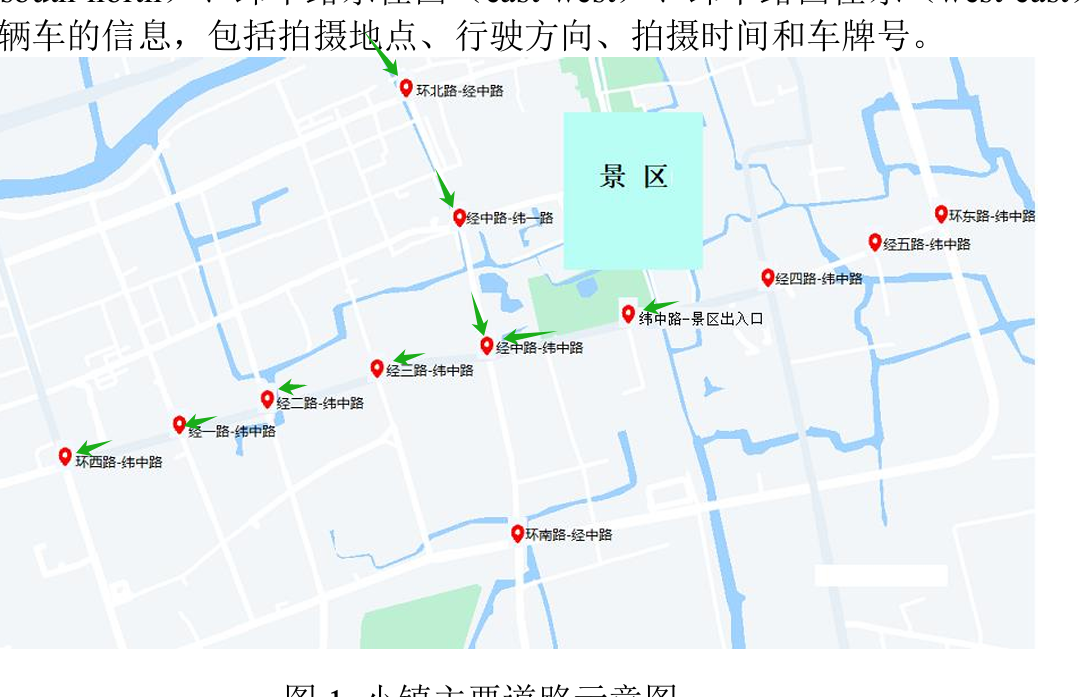

In [4]:
# 计算每辆车相邻两次出现的时间差（单位：秒）
original_data['时间差'] = original_data.groupby('车牌号')['时间'].diff().dt.total_seconds()
time_diff = original_data['时间差'].dropna()
time_diff.sort_values(inplace=True)
time_diff.describe()

count    8.120052e+06
mean     3.910177e+04
std      1.539726e+05
min      0.000000e+00
25%      7.943200e+01
50%      3.600000e+02
75%      1.457884e+04
max      3.105635e+06
Name: 时间差, dtype: float64

取时间间隔中位数360s作为是否为连续出现的判据，符合生活常识

In [5]:
time_diff_std = 360.0

In [6]:
# 定义相邻路口及其相对方向
adjacent_intersections = {
    '经中路-纬一路': '北',
    '环南路-经中路': '南',
    '经三路-纬中路': '西',
    '纬中路-景区出入口': '东'
}
# 定义方向与后方关系（假设与方向列一致）
reverse_direction = {
    '由东向西': '西',
    '由西向东': '东',
    '由南向北': '北',
    '由北向南': '南'
}

# 新增一列“转弯方向”，初始为空
original_data['转弯方向'] = np.nan

# 遍历每个车牌号
# 这里plate是车牌号，group是该车牌号对应的所有记录
for plate, group in original_data.groupby('车牌号'):
    idxs = group.index.tolist()
    for i in range(len(group) - 1):
        row = group.iloc[i]
        next_row = group.iloc[i + 1]
        # 只考虑当前出现在经中路-纬中路
        if row['交叉口'] == '经中路-纬中路':
            # 条件1：时间差
            time_diff = (next_row['时间'] - row['时间']).total_seconds()
            if time_diff <= time_diff_std:
                # 条件2：下次出现的路口是相邻路口
                next_intersection = next_row['交叉口']
                if next_intersection in adjacent_intersections:
                    # 条件3：下次出现的方向的后方对着经中路-纬中路
                    if reverse_direction.get(next_row['方向'], '') == adjacent_intersections[next_intersection]:
                        # 判定为一次转弯，记录转弯方向
                        original_data.at[row.name, '转弯方向'] = '自' + reverse_direction[row['方向']] + '向' +adjacent_intersections[next_intersection]
# 显示结果
original_data.head()
# ...existing code...

C:\Users\青柠二锅头\AppData\Local\Temp\ipykernel_3232\3866645441.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '自西向西' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  original_data.at[row.name, '转弯方向'] = '自' + reverse_direction[row['方向']] + '向' +adjacent_intersections[next_intersection]


,方向,时间,车牌号,交叉口,时间差,转弯方向
36395,由北向南,2024-04-01 17:16:15.624,3B04AU8,环西路-纬中路,NaN,NaN
2827631,由西向东,2024-04-01 17:18:59.713,3B04AU8,经二路-纬中路,164.089,NaN
3310793,由西向东,2024-04-01 17:20:46.845,3B04AU8,经三路-纬中路,107.132,NaN
4922568,由东向西,2024-04-01 19:07:34.000,3B04AU8,经中路-纬中路,6407.155,自西向西
3278655,由东向西,2024-04-01 19:08:41.471,3B04AU8,经三路-纬中路,67.471,NaN


In [7]:
turn_map = {
    '自北向东': '右转',
    '自北向西': '左转',
    '自北向南': '调头',
    '自北向北': '直行',
    '自南向西': '右转',
    '自南向东': '左转',
    '自南向北': '调头',   # 调头
    '自南向南': '直行',
    '自东向南': '右转',
    '自东向北': '左转',
    '自东向西': '调头',
    '自东向东': '直行',
    '自西向北': '右转',
    '自西向南': '左转',
    '自西向东': '调头',
    '自西向西': '直行',
}

original_data['Turning'] = original_data['转弯方向'].map(turn_map)

original_data



,方向,时间,车牌号,交叉口,时间差,转弯方向,Turning
36395,由北向南,2024-04-01 17:16:15.624,3B04AU8,环西路-纬中路,NaN,NaN,NaN
2827631,由西向东,2024-04-01 17:18:59.713,3B04AU8,经二路-纬中路,164.089,NaN,NaN
3310793,由西向东,2024-04-01 17:20:46.845,3B04AU8,经三路-纬中路,107.132,NaN,NaN
4922568,由东向西,2024-04-01 19:07:34.000,3B04AU8,经中路-纬中路,6407.155,自西向西,直行
3278655,由东向西,2024-04-01 19:08:41.471,3B04AU8,经三路-纬中路,67.471,NaN,NaN
...,...,...,...,...,...,...,...
7396459,由南向北,2024-04-26 13:38:51.000,礼OB367Y,经中路-纬一路,96.000,NaN,NaN
6735241,由南向北,2024-04-26 14:29:41.338,礼OB367Y,经中路-环北路,3050.338,NaN,NaN
6719735,由北向南,2024-04-26 15:19:03.591,礼OB367Y,经中路-环北路,2962.253,NaN,NaN
8625745,由西向东,2024-05-03 16:14:39.000,礼Q36CEA,经中路-环南路,NaN,NaN,NaN


## 工作日与非工作日有较大区别，需要分别考虑

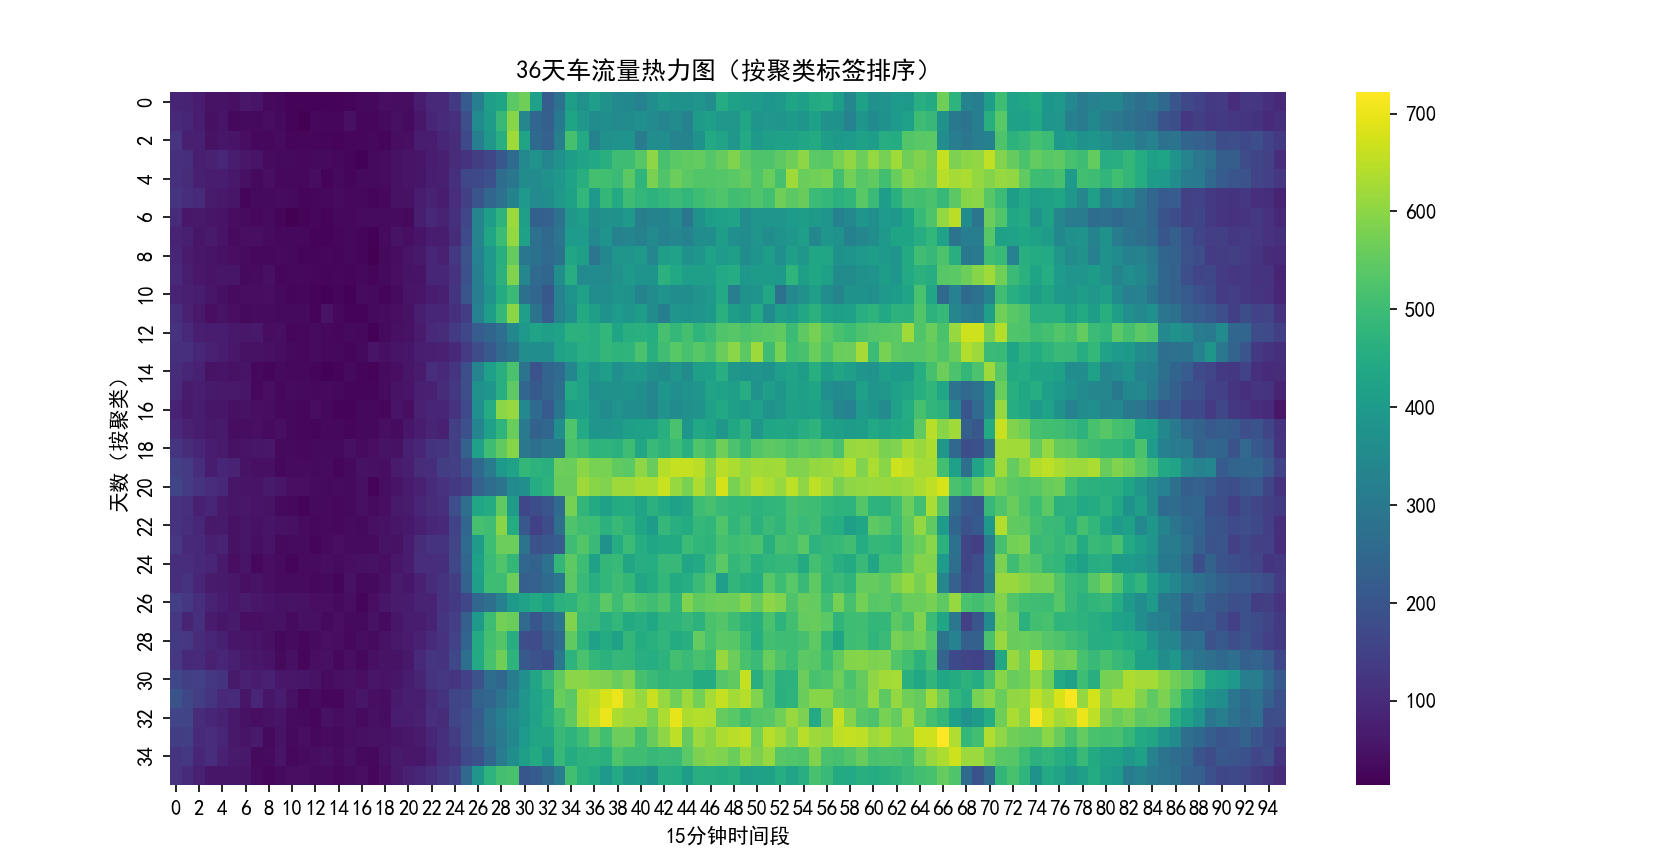

In [8]:

original_data["Hour"] = original_data["时间"].dt.hour
original_data['Month'] = original_data['时间'].dt.month
original_data

,方向,时间,车牌号,交叉口,时间差,转弯方向,Turning,Hour,Month
36395,由北向南,2024-04-01 17:16:15.624,3B04AU8,环西路-纬中路,NaN,NaN,NaN,17,4
2827631,由西向东,2024-04-01 17:18:59.713,3B04AU8,经二路-纬中路,164.089,NaN,NaN,17,4
3310793,由西向东,2024-04-01 17:20:46.845,3B04AU8,经三路-纬中路,107.132,NaN,NaN,17,4
4922568,由东向西,2024-04-01 19:07:34.000,3B04AU8,经中路-纬中路,6407.155,自西向西,直行,19,4
3278655,由东向西,2024-04-01 19:08:41.471,3B04AU8,经三路-纬中路,67.471,NaN,NaN,19,4
...,...,...,...,...,...,...,...,...,...
7396459,由南向北,2024-04-26 13:38:51.000,礼OB367Y,经中路-纬一路,96.000,NaN,NaN,13,4
6735241,由南向北,2024-04-26 14:29:41.338,礼OB367Y,经中路-环北路,3050.338,NaN,NaN,14,4
6719735,由北向南,2024-04-26 15:19:03.591,礼OB367Y,经中路-环北路,2962.253,NaN,NaN,15,4
8625745,由西向东,2024-05-03 16:14:39.000,礼Q36CEA,经中路-环南路,NaN,NaN,NaN,16,5


In [9]:
# 2. 筛选时间范围
mask = (original_data["时间"] >= "2024-04-01") & (original_data["时间"] <= "2024-05-06")
data_period = original_data.loc[mask].copy()

# 3. 定义2024年清明、五一假期和调休补班日
holidays = [
    "2024-04-04", "2024-04-05", "2024-04-06",  # 清明节
    "2024-05-01", "2024-05-02", "2024-05-03", "2024-05-04", "2024-05-05"  # 五一
]
extra_workdays = [
    "2024-04-07", "2024-04-28", "2024-05-11"  # 调休补班日
]

# 4. 新建日期列
data_period["Date"] = data_period["时间"].dt.date.astype(str)

# 5. 判断是否为假期或调休工作日
is_holiday = data_period["Date"].isin(holidays)
is_extra_workday = data_period["Date"].isin(extra_workdays)
is_weekend = data_period["时间"].dt.dayofweek >= 5  # 周六日

# 6. 工作日条件：不是周末且不是法定假日，或调休补班日
workday_mask = ((~is_weekend) & (~is_holiday)) | is_extra_workday
workdays = data_period.loc[workday_mask].copy()

# 7. 非工作日条件：周末或法定假日，且不是调休补班日
nonworkday_mask = (is_weekend | is_holiday) & (~is_extra_workday)
nonworkdays = data_period.loc[nonworkday_mask].copy()

# 8. 结果
# print("工作日样例：")
# print(workdays)
# print("非工作日样例：")
# print(nonworkdays)

工作日与非工作日数据分别为`workdays`、`nonworkdays`

In [10]:
workdays

,方向,时间,车牌号,交叉口,时间差,转弯方向,Turning,Hour,Month,Date
36395,由北向南,2024-04-01 17:16:15.624,3B04AU8,环西路-纬中路,NaN,NaN,NaN,17,4,2024-04-01
2827631,由西向东,2024-04-01 17:18:59.713,3B04AU8,经二路-纬中路,164.089,NaN,NaN,17,4,2024-04-01
3310793,由西向东,2024-04-01 17:20:46.845,3B04AU8,经三路-纬中路,107.132,NaN,NaN,17,4,2024-04-01
4922568,由东向西,2024-04-01 19:07:34.000,3B04AU8,经中路-纬中路,6407.155,自西向西,直行,19,4,2024-04-01
3278655,由东向西,2024-04-01 19:08:41.471,3B04AU8,经三路-纬中路,67.471,NaN,NaN,19,4,2024-04-01
...,...,...,...,...,...,...,...,...,...,...
3124748,由西向东,2024-04-26 13:36:01.589,礼OB367Y,经二路-纬中路,40.685,NaN,NaN,13,4,2024-04-26
5664261,由西向东,2024-04-26 13:37:15.000,礼OB367Y,经中路-纬中路,73.411,自东向北,左转,13,4,2024-04-26
7396459,由南向北,2024-04-26 13:38:51.000,礼OB367Y,经中路-纬一路,96.000,NaN,NaN,13,4,2024-04-26
6735241,由南向北,2024-04-26 14:29:41.338,礼OB367Y,经中路-环北路,3050.338,NaN,NaN,14,4,2024-04-26


### 工作日

打表保存一下进度

In [34]:
workdays.to_csv(r'D:\college\MCM\24\E\workdays.csv', index=False, encoding='gbk')
nonworkdays.to_csv(r'D:\college\MCM\24\E\nonworkdays.csv', index=False, encoding='gbk')

### 之后从这里开始即可

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

workdays= pd.read_csv(r'D:\college\MCM\24\E\workdays.csv', encoding='gbk')
nonworkdays= pd.read_csv(r'D:\college\MCM\24\E\nonworkdays.csv', encoding='gbk')

# 确保时间列是datetime类型
workdays['时间'] = pd.to_datetime(workdays['时间'])
nonworkdays['时间'] = pd.to_datetime(nonworkdays['时间'])

工作日与非工作日，经中路-纬中路的有效转弯或直行

In [36]:
workday_turn=workdays.dropna(axis=0, how='any', subset= ['转弯方向','Turning'])
nonworkday_turn=nonworkdays.dropna(axis=0, how='any', subset= ['转弯方向','Turning'])
workday_turn

,方向,时间,车牌号,交叉口,时间差,转弯方向,Turning,Hour,Month,Date
3,由东向西,2024-04-01 19:07:34,3B04AU8,经中路-纬中路,6407.155,自西向西,直行,19,4,2024-04-01
7,由北向南,2024-04-29 10:17:41,3B07ADI,经中路-纬中路,47.000,自南向西,右转,10,4,2024-04-29
16,由南向北,2024-04-17 13:20:28,3B1CB0F,经中路-纬中路,139.000,自北向北,直行,13,4,2024-04-17
21,由北向南,2024-04-17 14:07:41,3B1CB0F,经中路-纬中路,98.000,自南向东,左转,14,4,2024-04-17
25,由南向北,2024-04-23 13:13:20,3B1CB0F,经中路-纬中路,158.000,自北向北,直行,13,4,2024-04-23
...,...,...,...,...,...,...,...,...,...,...
5004918,由南向北,2024-04-17 18:36:50,礼O5AG8F,经中路-纬中路,65.000,自北向北,直行,18,4,2024-04-17
5004926,由南向北,2024-04-25 13:23:11,礼O5AG8F,经中路-纬中路,178.000,自北向北,直行,13,4,2024-04-25
5004934,由南向北,2024-04-26 14:05:11,礼O5AG8F,经中路-纬中路,77.000,自北向北,直行,14,4,2024-04-26
5004993,由西向东,2024-04-19 13:41:12,礼OB367Y,经中路-纬中路,103.105,自东向北,左转,13,4,2024-04-19


In [37]:


# 创建15分钟时段分组标签 (0-95)
def get_time_period(timestamp):
    return timestamp.hour * 4 + timestamp.minute // 15

# 添加时段分组列
workday_turn['时段'] = workday_turn['时间'].apply(get_time_period)
nonworkday_turn['时段'] = nonworkday_turn['时间'].apply(get_time_period)

# 定义需要统计的转弯方向
directions = ['左转', '右转', '直行', '调头']

# 按时段分组并统计各方向数量
work_result = (
    workday_turn[workday_turn['Turning'].isin(directions)]
    .groupby('时段')['Turning']
    .value_counts()
    .unstack(fill_value=0)
    .reindex(columns=directions, fill_value=0)
)

nonwork_result = (
    nonworkday_turn[nonworkday_turn['Turning'].isin(directions)]
    .groupby('时段')['Turning']
    .value_counts()
    .unstack(fill_value=0)
    .reindex(columns=directions, fill_value=0)
)

# # 补全所有时段 (0-95)
# result = result.reindex(range(96), fill_value=0).reset_index()

C:\Users\青柠二锅头\AppData\Local\Temp\ipykernel_2476\135138675.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  workday_turn['时段'] = workday_turn['时间'].apply(get_time_period)
C:\Users\青柠二锅头\AppData\Local\Temp\ipykernel_2476\135138675.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonworkday_turn['时段'] = nonworkday_turn['时间'].apply(get_time_period)


In [38]:
print(nonwork_result)
work_result

Turning   左转   右转   直行  调头
时段                        
0        140  227  473  11
1        110  206  496   6
2        108  176  345   5
3         91  161  327   6
4         71  130  302   2
..       ...  ...  ...  ..
91       200  429  851   9
92       192  388  826  12
93       189  340  730   8
94       147  277  606   7
95       129  252  521   6

[96 rows x 4 columns]


Turning,左转,右转,直行,调头
时段,,,,
0,151,296,610,6
1,122,243,520,3
2,121,208,444,5
3,78,177,396,1
4,90,147,343,3
...,...,...,...,...
91,233,446,1007,2
92,271,430,955,14
93,278,398,886,10


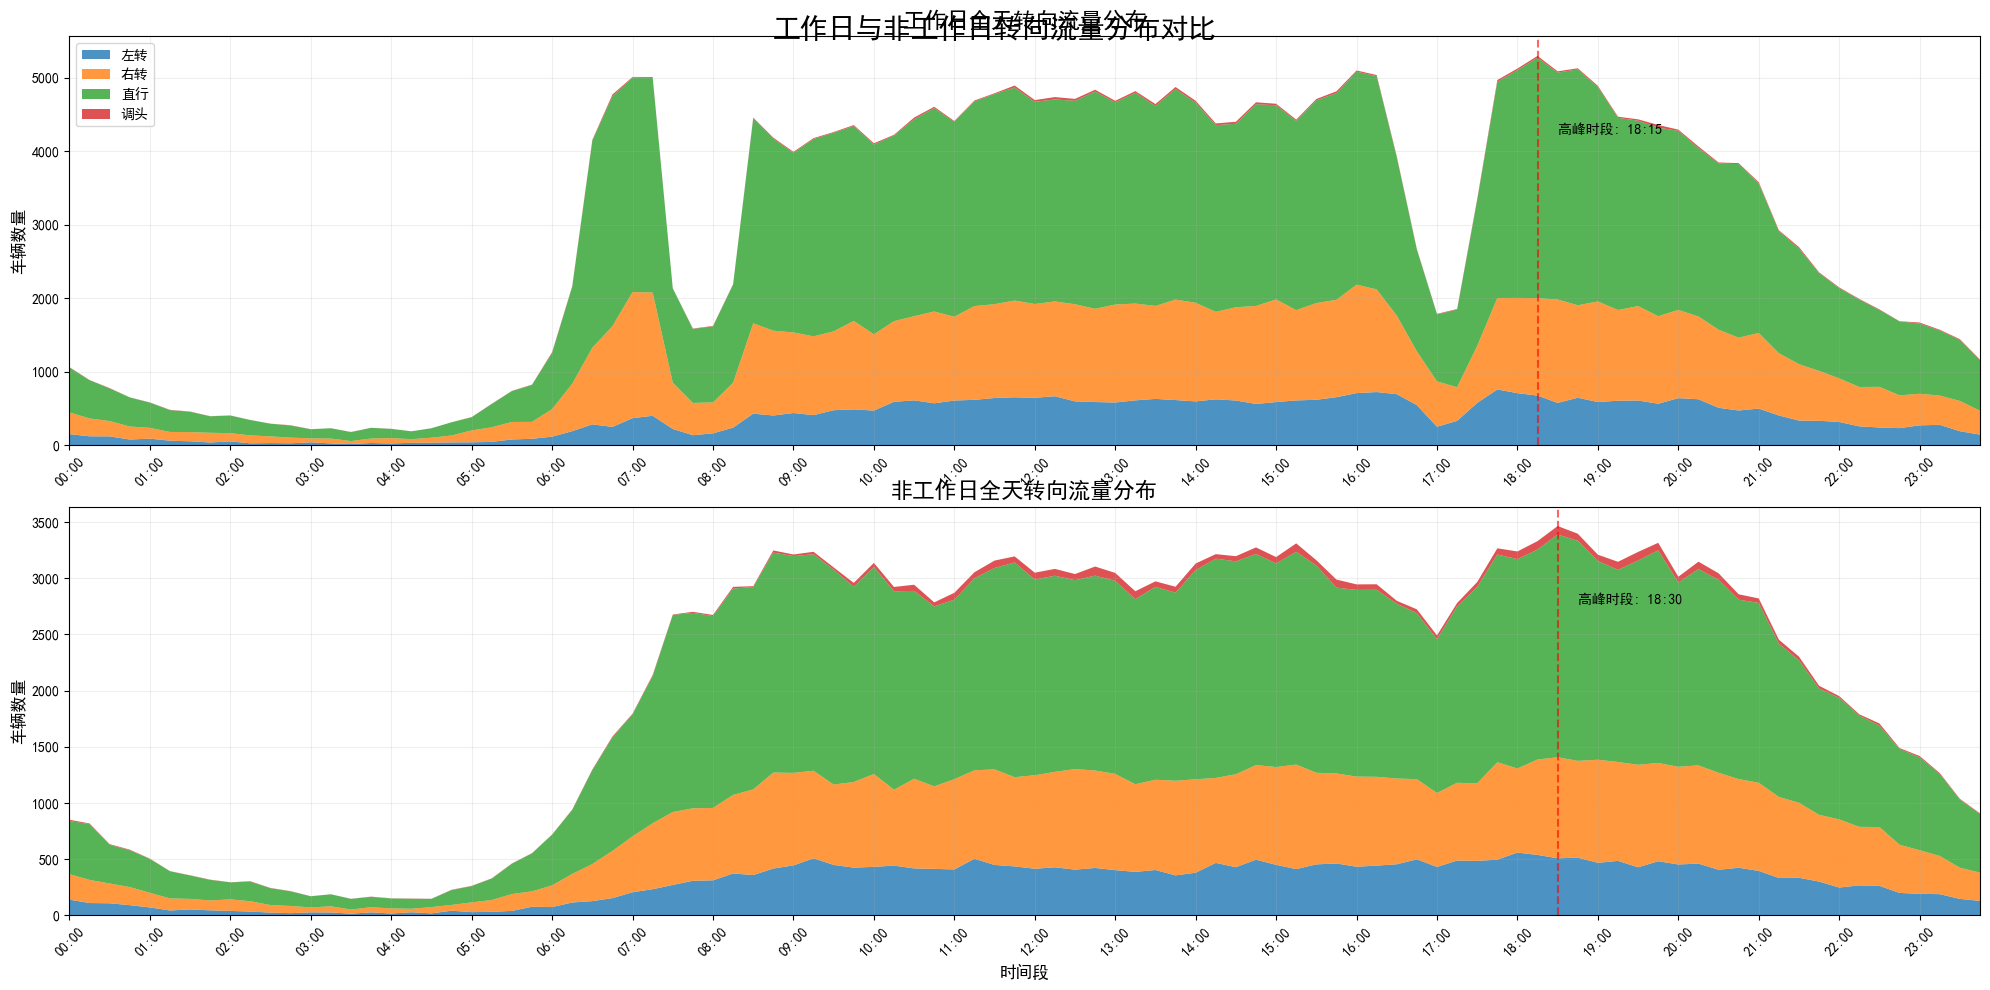

In [29]:
# 准备时间标签
time_labels = [f"{h//4:02d}:{15*(h%4):02d}" for h in range(96)]

plt.figure(figsize=(20, 10))
directions = ['左转', '右转', '直行', '调头']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# 设置中文字体和负号显示
plt.rcParams['font.family']="SimHei" 
plt.rcParams['axes.unicode_minus']='false'

# 工作日流量（上半部分）
plt.subplot(2, 1, 1)
plt.stackplot(range(96), 
              work_result['左转'], 
              work_result['右转'], 
              work_result['直行'], 
              work_result['调头'],
              labels=directions,
              colors=colors,
              alpha=0.8)

# 标记工作日高峰时段
work_peak_index = np.argmax(work_result[directions].sum(axis=1))
work_peak_time = time_labels[work_peak_index]
plt.axvline(x=float(work_peak_index), color='r', linestyle='--', alpha=0.6)
plt.text(float(work_peak_index)+1, np.max(work_result[directions].sum(axis=1))*0.8, 
         f'高峰时段: {work_peak_time}', fontsize=10)

plt.xticks(np.arange(0, 96, 4), time_labels[::4], rotation=45)
plt.xlim(0, 95)
plt.title('工作日全天转向流量分布', fontsize=16)
plt.ylabel('车辆数量', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(alpha=0.2)

# 非工作日流量（下半部分）
plt.subplot(2, 1, 2)
plt.stackplot(range(96), 
              nonwork_result['左转'], 
              nonwork_result['右转'], 
              nonwork_result['直行'], 
              nonwork_result['调头'],
              labels=directions,
              colors=colors,
              alpha=0.8)

# 标记非工作日高峰时段
nonwork_peak_index = np.argmax(nonwork_result[directions].sum(axis=1))
nonwork_peak_time = time_labels[nonwork_peak_index]
plt.axvline(x=float(nonwork_peak_index), color='r', linestyle='--', alpha=0.6)
plt.text(float(nonwork_peak_index)+1, np.max(nonwork_result[directions].sum(axis=1))*0.8, 
         f'高峰时段: {nonwork_peak_time}', fontsize=10)

plt.xticks(np.arange(0, 96, 4), time_labels[::4], rotation=45)
plt.xlim(0, 95)
plt.title('非工作日全天转向流量分布', fontsize=16)
plt.xlabel('时间段', fontsize=12)
plt.ylabel('车辆数量', fontsize=12)
plt.grid(alpha=0.2)

plt.tight_layout()
plt.subplots_adjust(hspace=0.15)
plt.suptitle('工作日与非工作日转向流量分布对比', fontsize=20, y=0.98)
plt.show()

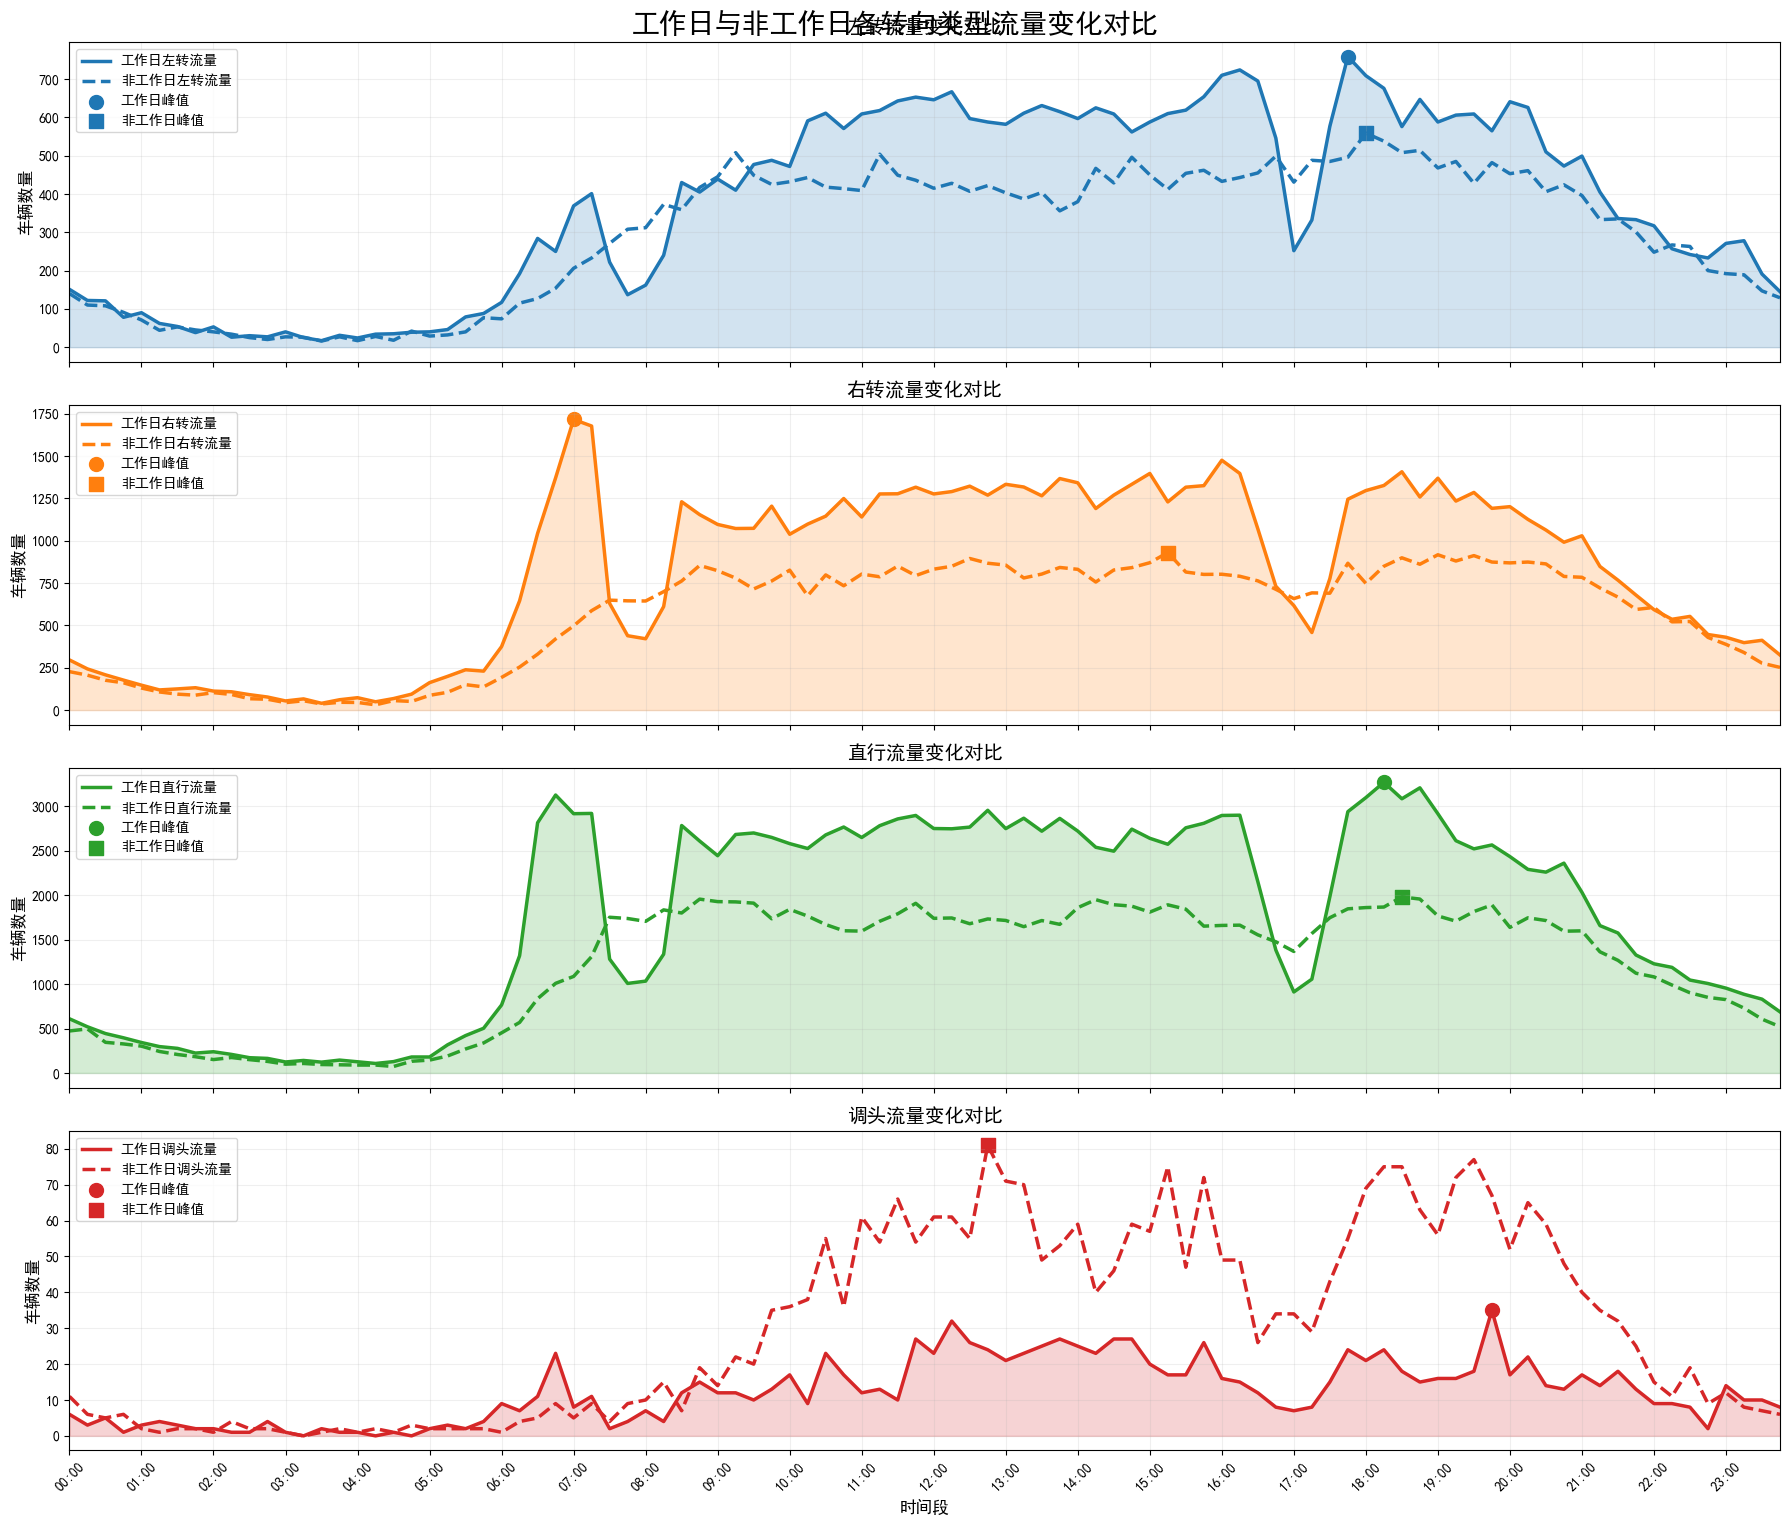

In [30]:
fig, axes = plt.subplots(4, 1, figsize=(18, 16), sharex=True)

# 设置中文字体和负号显示
plt.rcParams['font.family']="SimHei" 
plt.rcParams['axes.unicode_minus']='false'

for i, direction in enumerate(directions):
    ax = axes[i]
    
    # 工作日曲线（实线）
    ax.plot(range(96), work_result[direction], 
            color=colors[i], linewidth=2.5, 
            label=f'工作日{direction}流量')
    
    # 非工作日曲线（虚线）
    ax.plot(range(96), nonwork_result[direction], 
            color=colors[i], linewidth=2.5, linestyle='--',
            label=f'非工作日{direction}流量')
    
    # 填充曲线下方区域
    ax.fill_between(range(96), work_result[direction], alpha=0.2, color=colors[i])
    
    # 标记峰值
    work_max_index = np.argmax(work_result[direction])
    nonwork_max_index = np.argmax(nonwork_result[direction])
    ax.scatter(work_max_index, work_result[direction][work_max_index], 
              color=colors[i], s=100, marker='o', label='工作日峰值')
    ax.scatter(nonwork_max_index, nonwork_result[direction][nonwork_max_index], 
              color=colors[i], s=100, marker='s', label='非工作日峰值')
    
    ax.set_title(f'{direction}流量变化对比', fontsize=14)
    ax.set_ylabel('车辆数量', fontsize=12)
    ax.grid(alpha=0.2)
    ax.legend(loc='upper left')

# 设置公共x轴标签和刻度
axes[-1].set_xlabel('时间段', fontsize=12)
axes[-1].set_xticks(np.arange(0, 96, 4))
axes[-1].set_xticklabels(time_labels[::4], rotation=45)
axes[-1].set_xlim(0, 95)

plt.suptitle('工作日与非工作日各转向类型流量变化对比', fontsize=20, y=0.95)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

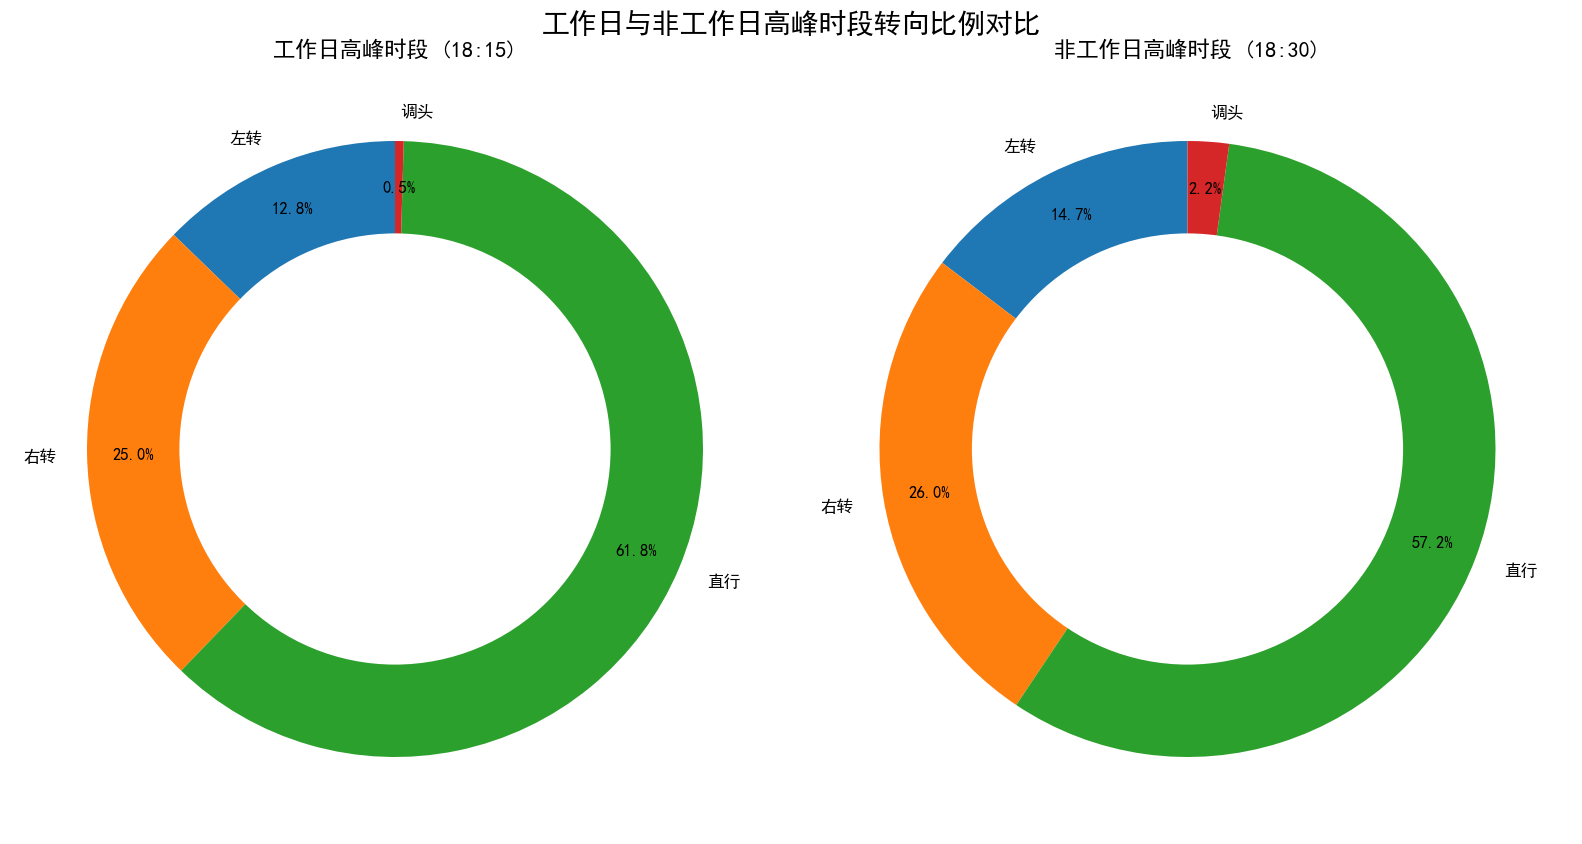

In [31]:
# 找出工作日和非工作日的高峰时段
work_peak_period = work_result.iloc[work_peak_index][directions]
nonwork_peak_period = nonwork_result.iloc[nonwork_peak_index][directions]

# 创建双环状图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# 工作日高峰时段转向比例
wedges1, texts1, autotexts1 = ax1.pie(
    work_peak_period, 
    labels=directions, 
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    pctdistance=0.85,
    textprops={'fontsize': 12}
)
centre_circle1 = patches.Circle((0,0), 0.70, fc='white')
ax1.add_artist(centre_circle1)
ax1.set_title(f'工作日高峰时段 ({work_peak_time})', fontsize=16)

# 非工作日高峰时段转向比例
wedges2, texts2, autotexts2 = ax2.pie(
    nonwork_peak_period, 
    labels=directions, 
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    pctdistance=0.85,
    textprops={'fontsize': 12}
)
centre_circle2 = patches.Circle((0,0), 0.70, fc='white')
ax2.add_artist(centre_circle2)
ax2.set_title(f'非工作日高峰时段 ({nonwork_peak_time})', fontsize=16)

# 设置颜色和字体大小
plt.setp(autotexts1, size=12, weight="bold")
plt.setp(autotexts2, size=12, weight="bold")
plt.tight_layout()
plt.suptitle('工作日与非工作日高峰时段转向比例对比', fontsize=20, y=1.05)
plt.show()

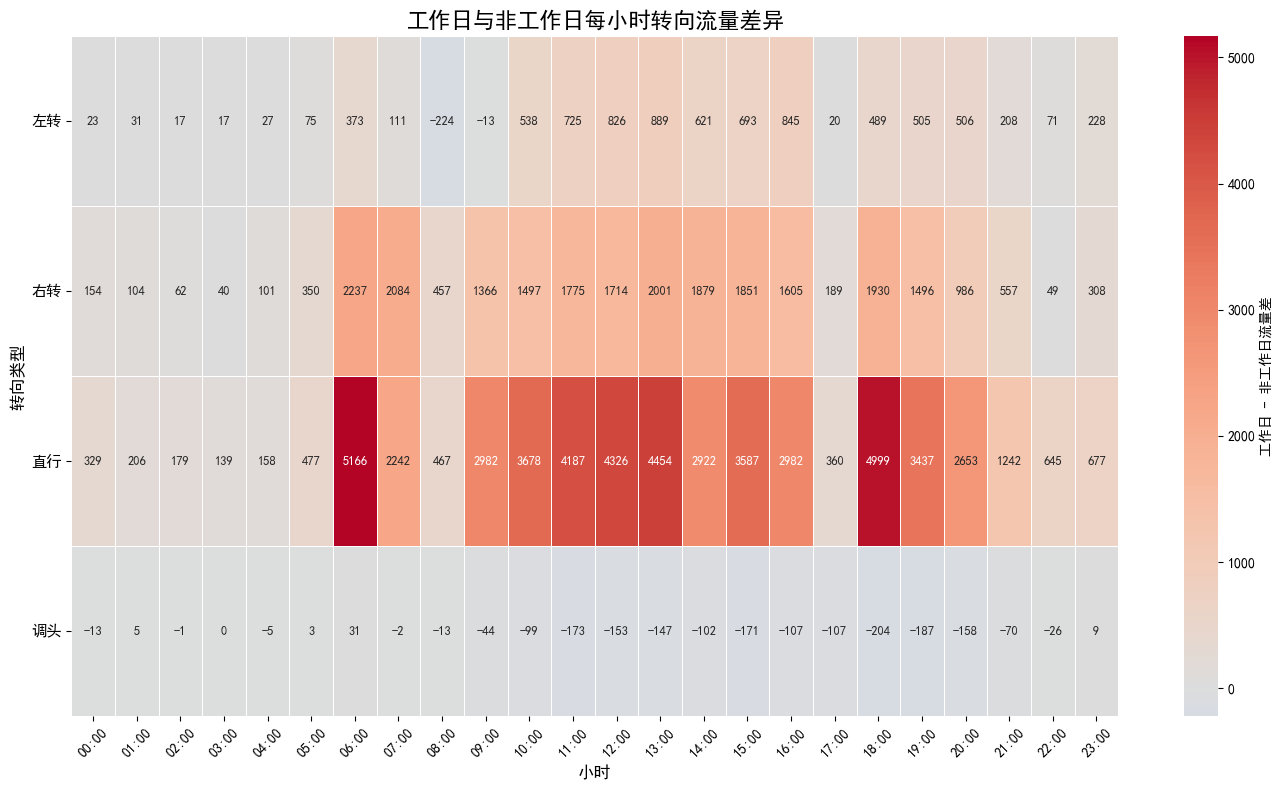

In [41]:
import seaborn as sns
# 计算工作日与非工作日流量差异
hourly_diff = work_hourly.copy()
for direction in directions:
    hourly_diff[direction] = work_hourly[direction] - nonwork_hourly[direction]

# 创建热力图
plt.figure(figsize=(14, 8))

# 创建差异热力图
sns.heatmap(
    hourly_diff[directions].T,  # 转置矩阵使小时在x轴，转向在y轴
    annot=True,
    fmt=".0f",
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    annot_kws={"size": 9},
    cbar_kws={'label': '工作日 - 非工作日流量差'}
)

# 设置标签
plt.xlabel('小时', fontsize=12)
plt.ylabel('转向类型', fontsize=12)
plt.yticks(ticks=np.arange(0.5, 4), labels=directions, rotation=0, fontsize=11)
plt.xticks(ticks=np.arange(24)+0.5, labels=[f"{h:02d}:00" for h in range(24)], rotation=45)
plt.title('工作日与非工作日每小时转向流量差异', fontsize=16)
plt.tight_layout()
plt.show()

### 奇怪的数据出现了


存在间隔为0s的记录，一辆车同时在两个方向被拍摄到

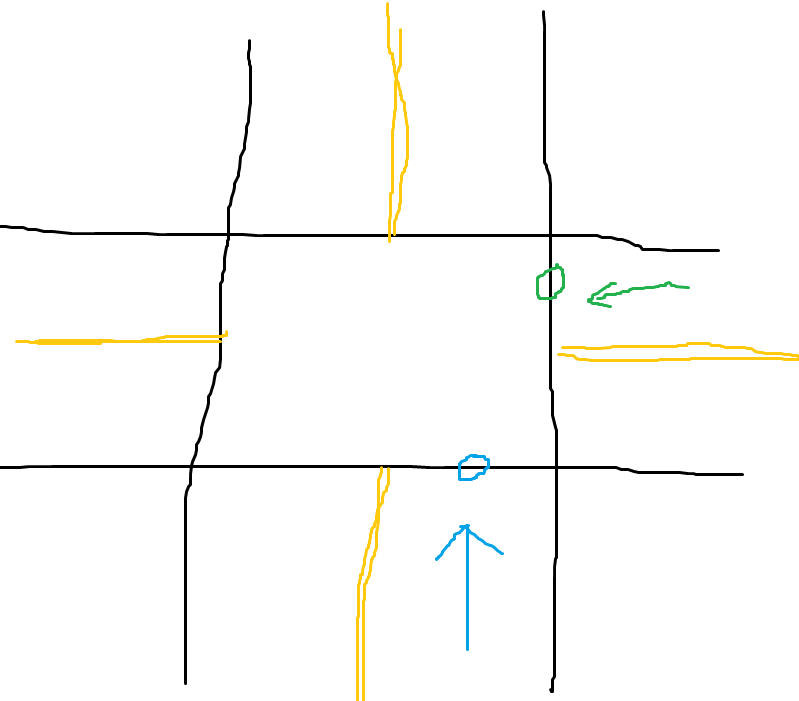

In [9]:
original_data.loc[original_data['时间差']==0.0, :]

,方向,时间,车牌号,交叉口,Hour,Month,时间差
7405430,由南向北,2024-04-26 10:48:07,AF2CCY8,经中路-纬一路,10,4,0.0
7085734,由东向西,2024-04-12 07:11:22,AF3P679,经中路-纬一路,7,4,0.0
5458452,由西向东,2024-04-19 00:32:25,AF4E786K,经中路-纬中路,0,4,0.0
7817945,由西向东,2024-04-05 20:12:19,AF7JAA2,经中路-环南路,20,4,0.0
7145600,由东向西,2024-04-15 10:25:49,AFA45MB,经中路-纬一路,10,4,0.0
7161533,由北向南,2024-04-14 18:43:11,AFS3417,经中路-纬一路,18,4,0.0


In [ ]:
original_data.loc[(original_data['车牌号']=='AF3P679') & (original_data['时间']=='2024-04-12 07:11:22'),:].copy()

,方向,时间,车牌号,交叉口,Hour,Month,时间差
7083234,由南向北,2024-04-12 07:11:22,AF3P679,经中路-纬一路,7,4,3.0
7085734,由东向西,2024-04-12 07:11:22,AF3P679,经中路-纬一路,7,4,0.0


## 根据交叉口和方向分组

grouped 的键是 (交叉口, 方向) 的元组，值是对应的小表格

In [11]:
grouped = dict(tuple(original_data.groupby(['交叉口', '方向'])))

print(grouped.keys())

# 例如，查看“环西路-纬中路”交叉口，“东”方向的数据
grouped[('环西路-纬中路', 1)]  #这玩意的类型是DataFrame

dict_keys([('环东路-纬中路', '由东向西'), ('环东路-纬中路', '由北向南'), ('环东路-纬中路', '由南向北'), ('环东路-纬中路', '由西向东'), ('环西路-纬中路', '由东向西'), ('环西路-纬中路', '由北向南'), ('环西路-纬中路', '由南向北'), ('环西路-纬中路', '由西向东'), ('纬中路-景区出入口', '由东向西'), ('纬中路-景区出入口', '由北向南'), ('纬中路-景区出入口', '由南向北'), ('纬中路-景区出入口', '由西向东'), ('经一路-纬中路', '由东向西'), ('经一路-纬中路', '由北向南'), ('经一路-纬中路', '由南向北'), ('经一路-纬中路', '由西向东'), ('经三路-纬中路', '由东向西'), ('经三路-纬中路', '由北向南'), ('经三路-纬中路', '由南向北'), ('经三路-纬中路', '由西向东'), ('经中路-环北路', '由东向西'), ('经中路-环北路', '由北向南'), ('经中路-环北路', '由南向北'), ('经中路-环北路', '由西向东'), ('经中路-环南路', '由东向西'), ('经中路-环南路', '由北向南'), ('经中路-环南路', '由南向北'), ('经中路-环南路', '由西向东'), ('经中路-纬一路', '由东向西'), ('经中路-纬一路', '由北向南'), ('经中路-纬一路', '由南向北'), ('经中路-纬一路', '由西向东'), ('经中路-纬中路', '由东向西'), ('经中路-纬中路', '由北向南'), ('经中路-纬中路', '由南向北'), ('经中路-纬中路', '由西向东'), ('经二路-纬中路', '由东向西'), ('经二路-纬中路', '由西向东'), ('经五路-纬中路', '由东向西'), ('经五路-纬中路', '由北向南'), ('经五路-纬中路', '由南向北'), ('经五路-纬中路', '由西向东'), ('经四路-纬中路', '由东向西'), ('经四路-纬中路', '由北向南'), ('经四路-纬中路', '由南向北'), ('经四路-纬中路', '由西向东')])


KeyError: ('环西路-纬中路', 1)